# Credit risk
The possibility that someone who has borrowed money will not repay it all
Calculated risk difference between lending someone money and a government bond
When someone fails to repay a loan, it is said to be in default
The likelihood that someone will default on a loan is the probability of default (PD)

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("cr_loan2.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [2]:
pd.crosstab(df['person_home_ownership'], df['loan_status'],values=df['loan_int_rate'], aggfunc='mean').round(2)

loan_status,0,1
person_home_ownership,,
MORTGAGE,10.06,13.43
OTHER,11.41,13.56
OWN,10.75,12.24
RENT,10.75,12.97


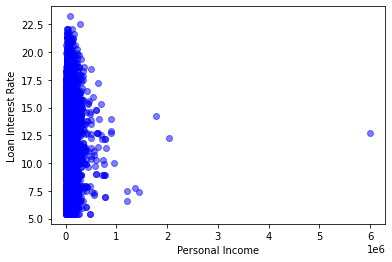

In [4]:
import matplotlib.pyplot as plt
plt.scatter(df['person_income'], df['loan_int_rate'],c='blue', alpha=0.5)
plt.xlabel("Personal Income")
plt.ylabel("Loan Interest Rate")
plt.show()

In [5]:
# check outlier
indices = df[df['person_emp_length'] >= 60].index
df.drop(indices, inplace=True)

### Missing data

In [7]:
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

person_emp_length     895
loan_int_rate        3116
dtype: int64

In [8]:
# mean
df['loan_int_rate'].fillna((df['loan_int_rate'].mean()), inplace = True)

In [9]:
# Dropping missing data
indices = df[df['person_emp_length'].isnull()].index
df.drop(indices, inplace=True)

# Logistic Regression

#### basic

In [43]:
from sklearn.linear_model import LogisticRegression
# Create the X and y data sets
X = df[['loan_int_rate','person_emp_length','person_income']]
y = df[['loan_status']]

# Create and fit a logistic regression model
clf_logistic_single = LogisticRegression(solver='lbfgs')
clf_logistic_single.fit(X, np.ravel(y))

# Print the parameters of the model
print(clf_logistic_single.get_params())

# Print the intercept of the model
print(clf_logistic_single.intercept_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[-0.00098878]


### Creating the training and test sets

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [19]:
# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
print(clf_logistic.coef_)

[[ 7.39564632e-02 -1.56092683e-02 -3.43582345e-05]]


In [65]:

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df_lr = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            1      0.366885
1            0      0.037761
2            0      0.031798
3            0      0.088423
4            0      0.184025


### Visually scoring credit models

0.804244910841092


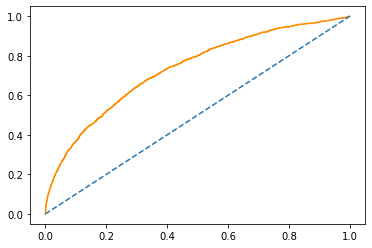

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

# Print the accuracy score the model
print(clf_logistic.score(X_test, y_test))

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)

In [68]:
from sklearn.metrics import classification_report
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

# Print the row counts for each loan status
print(preds_df['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

0    11885
1      789
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89      9976
     Default       0.64      0.19      0.29      2698

    accuracy                           0.80     12674
   macro avg       0.73      0.58      0.59     12674
weighted avg       0.78      0.80      0.76     12674



In [28]:
from sklearn.metrics import confusion_matrix
# Print the confusion matrix
print(confusion_matrix(y_test,preds_df['loan_status']))

[[9690  286]
 [2195  503]]


### How thresholds affect performance

In [31]:
from sklearn.metrics import precision_recall_fscore_support
# Reassign the values of loan status based on the new threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
print(num_defaults * df['loan_amnt'].mean()* (1 - default_recall))

13113254.121102672


plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(ticks)
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

# Gradient boosted trees with XGBoost

!pip install --user xgboost

In [69]:
# Train a model
import xgboost as xgb
clf_gbt = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 4).fit(X_train, np.ravel(y_train)) 
# Hyperparameters of gradient boosted trees

# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df_gbt = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

       loan_status  prob_default  loan_status
0              1.0      0.360448            0
1              0.0      0.028093            0
2              0.0      0.145718            0
3              0.0      0.233038            0
4              0.0      0.308184            0
...            ...           ...          ...
12669          NaN      0.477771            0
12670          NaN      0.113305            0
12671          NaN      0.176494            0
12672          NaN      0.154340            0
12673          NaN      0.383273            0

[12674 rows x 3 columns]


In [70]:
from sklearn.metrics import classification_report
# Create a dataframe for the probabilities of default
preds_df_gbt = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_gbt['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

# Print the row counts for each loan status
print(preds_df_gbt['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))

0    11885
1      789
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89      9976
     Default       0.64      0.19      0.29      2698

    accuracy                           0.80     12674
   macro avg       0.73      0.58      0.59     12674
weighted avg       0.78      0.80      0.76     12674



### Plotting column importances

In [45]:
# Train the model
clf_gbt.fit(X_train,np.ravel(y_train))
# Print the feature importances
clf_gbt.get_booster().get_score(importance_type = 'weight')

{'loan_int_rate': 428, 'person_income': 688, 'person_emp_length': 159}

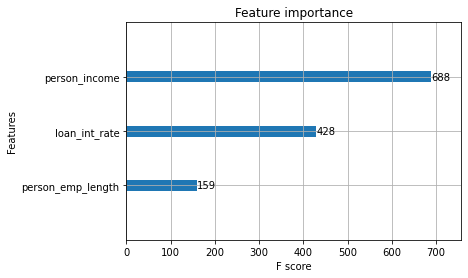

In [46]:
xgb.plot_importance(clf_gbt, importance_type = 'weight')

# Setting up cross validation within XGBoost

In [47]:
# Set the number of folds
n_folds = 2
# Set early stopping number
early_stop = 5
# Set any specific parameters for cross validation
params = {'objective': 'binary:logistic',
'seed': 99, 'eval_metric':'auc'}

In [54]:
# Restructure the train data for xgboost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Perform cross validation
xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
early_stopping_rounds=early_stop)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.819829,0.003326,0.800998,0.005273
1,0.827592,0.000997,0.806949,0.005011
2,0.830533,0.001444,0.809237,0.003536
3,0.835527,0.003558,0.812831,0.003022
4,0.840819,0.002481,0.815319,0.004053


In [56]:
# Import the module
from sklearn.model_selection import cross_val_score
# Create a gbt model
xg = xgb.XGBClassifier(learning_rate = 0.4, max_depth = 10)
# Use cross valudation and accuracy scores 5 consecutive times
cross_val_score(xg, X_train, y_train, cv = 5)

C:\Users\chunx\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0.83903209, 0.83403472, 0.82956339, 0.84560757, 0.83035245])

## Dealing with class imbalance

In [57]:
y_train['loan_status'].value_counts()

0    14883
1     4127
Name: loan_status, dtype: int64

In [59]:
#Concat the training sets
X_y_train = pd.concat([X_train.reset_index(drop = True),
y_train.reset_index(drop = True)], axis = 1)
# Get the counts of defaults and non-defaults
count_nondefault, count_default = X_y_train['loan_status'].value_counts()
# Separate nondefaults and defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

In [60]:
# Undersample the non-defaults using sample() in pandas
nondefaults_under = nondefaults.sample(count_default)
# Concat the undersampled non-defaults with the defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
defaults.reset_index(drop = True)], axis=0)

### One-hot encoding credit data
It's time to prepare the non-numeric columns so they can be added to your LogisticRegression() model.

In [20]:


# Create two data sets for numeric and non-numeric data
cred_num = df.select_dtypes(exclude=['object'])
cred_str = df.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
df_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
print(df_prep.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')


# Model evaluation and implementation

In [62]:
from sklearn.calibration import calibration_curve
calibration_curve(y_test, prob_default, n_bins = 5)

(array([0.09750362, 0.2184476 , 0.45740741, 0.85271318]),
 array([0.09822022, 0.29386095, 0.47523034, 0.63522285]))

In [71]:
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))

# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test,preds_df ['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test,preds_df_gbt['loan_status'], average = 'macro')[2])

              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89      9976
     Default       0.64      0.19      0.29      2698

    accuracy                           0.80     12674
   macro avg       0.73      0.58      0.59     12674
weighted avg       0.78      0.80      0.76     12674

              precision    recall  f1-score   support

 Non-Default       0.82      0.97      0.89      9976
     Default       0.64      0.19      0.29      2698

    accuracy                           0.80     12674
   macro avg       0.73      0.58      0.59     12674
weighted avg       0.78      0.80      0.76     12674

0.5875051835378748
0.5875051835378748


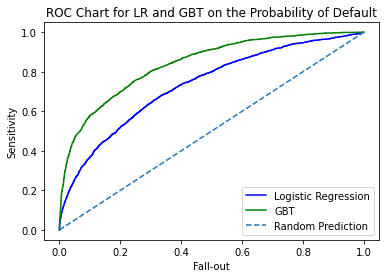

In [72]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, preds[:, 1])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, gbt_preds[:,1])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Calibration Curve')

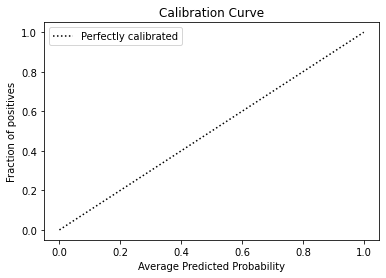

In [75]:
# Create the calibration curve plot with the guideline
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')


#plt.show()

In [ ]:
# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted Tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

# Credit Acceptance rates

In [ ]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

In [80]:
# Compute the threshold for 85% acceptance rate
threshold = np.quantile(prob_default, 0.85)
threshold

0.4221664124794408

In [81]:
# Compute the quantile on the probabilities of default
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.42 else 0)

# Selecting acceptance rates

In [103]:
# Check the statistics of the probabilities of default
print(preds_df['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(preds_df['prob_default'], 0.85)

# Apply acceptance rate threshold
preds_df['pred_loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(preds_df['pred_loan_status'].value_counts())

count    1.267400e+04
mean     2.429135e-01
std      1.553513e-01
min      6.273910e-90
25%      1.140948e-01
50%      2.289610e-01
75%      3.571548e-01
max      7.264546e-01
Name: prob_default, dtype: float64
0    10773
1     1901
Name: pred_loan_status, dtype: int64


# Credit strategy and minimum expected loss


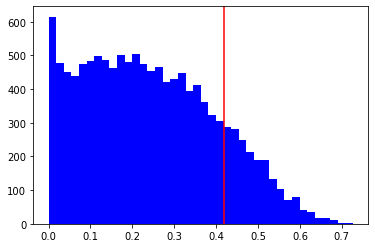

In [132]:
# Plot the predicted probabilities of default
plt.hist(preds_df_gbt['prob_default'] , color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(preds_df_gbt, 0.85)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

preds_df_gbt['known loan status']=df['loan_status']
preds_df_gbt=preds_df_gbt.dropna()
#########Create a subset of only accepted loans
accepted_loans = preds_df_gbt[preds_df_gbt['loan_status'] == 0]

##########Calculate the bad rate
print(np.sum(accepted_loans['known loan status']) / accepted_loans['known loan status'].count())

In [154]:
# Set all the acceptance rates to test
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55,0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
# Create lists to store thresholds and bad rates
thresholds = []
bad_rates = []

# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
  	# Calculate the threshold for the acceptance rate
    thresh = np.quantile(preds_df_gbt['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df_gbt['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    preds_df_gbt['pred_loan_status'] = \
    preds_df_gbt['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    preds_df_gbt['known loan status']=df['loan_status']
    preds_df_gbt=preds_df_gbt.dropna()
    accepted_loans = preds_df_gbt[preds_df_gbt['pred_loan_status'] == 0]
    
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['known loan status']) / len(accepted_loans['known loan status'])).round(3))

In [155]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])


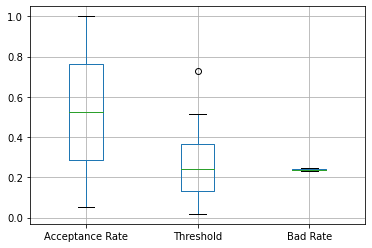

In [156]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

#### Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [149]:
strat_df['loan_amnt']=df['loan_amnt']
strat_df['loss_given_default']= preds_df_gbt['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)
strat_df['prob_default'] =preds_df_gbt['prob_default']

In [150]:
# Print the first five rows of the data frame
print(strat_df.head())

# Calculate the bank's expected loss and assign it to a new column
strat_df['expected_loss'] = strat_df['prob_default'] * strat_df['loan_amnt'] * strat_df['loss_given_default']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(strat_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

   Acceptance Rate  Threshold  Bad Rate  Estimated Value  loan_amnt  \
0             1.00      0.726     0.235      2270.149768        NaN   
1             0.95      0.516     0.236      2279.809980     1000.0   
2             0.90      0.463     0.236      2279.809980     5500.0   
3             0.85      0.422     0.236      2279.809980    35000.0   
4             0.80      0.386     0.237      2289.470192    35000.0   

   loss_given_default  prob_default  
0                 NaN           NaN  
1                 0.0      0.028093  
2                 0.0      0.145718  
3                 0.0      0.233038  
4                 0.0      0.308184  
Total expected loss:  $63,459.27
